In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error

In [89]:
# Variabili globali

path = 'pala_ok/fullDischargeGoodmotor/'

In [90]:
allacqui_NI = []
allacqui_RPM = []
allacqui_Volts = []

# Andiamo a prendere tutti i path dei vari file
path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


In [91]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,len(path_acquisizioni))):
    if("NI" in a):
        try:
            allacqui_NI.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
        except:
            allacqui_NI.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['Time'],keep='last',ignore_index=True))
    elif("RPM" in a):
        allacqui_RPM.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    elif("Volts" in a):
        allacqui_Volts.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))


(10390,)
(10390,)
(10390,)



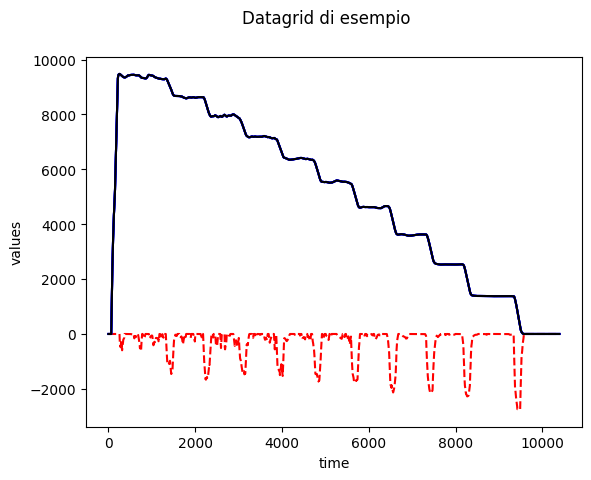

In [92]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media
allacqui_RPM[1]['rpm'] = allacqui_RPM[1]['rpm'].rolling(150,min_periods = 1,center=False).mean()
grid_points = []
data_matrix = np.array(allacqui_RPM[1]['rpm'])
grid_points = np.arange(allacqui_RPM[1].shape[0])
gradient = np.gradient(allacqui_RPM[1]['rpm'],grid_points)
gradmask = (gradient>0) | (gradient<-10)
gradient[gradmask] = 0
gradient = gradient*300
#pd.DataFrame(gradient).to_csv("./grad.csv")
rollmax = np.array(pd.DataFrame(gradient).rolling(100,min_periods = 1,center=False).max())[:,0]
print(grid_points.shape)
print(gradient.shape)
print(rollmax.shape)

fd_manu = skfda.FDataGrid(
    data_matrix=np.array([data_matrix,gradient]),
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=1)
)
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
print()

           0
0       12.0
1       71.0
2      122.0
3      177.0
4      215.0
...      ...
1559  2752.0
1560  2753.0
1561  2754.0
1562  2761.0
1563  2768.0

[1564 rows x 1 columns]
1563    2768.0
1562    2761.0
1561    2754.0
1560    2753.0
1559    2752.0
1558    2752.0
1557    2751.0
1556    2750.0
1555    2749.0
1554    2748.0
Name: 0, dtype: float64


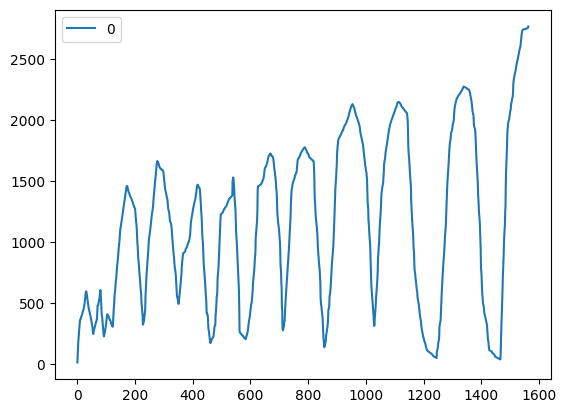

In [98]:
Nonzerograd = -1*gradient[gradient != 0]
rollmax = pd.DataFrame(pd.DataFrame(Nonzerograd).rolling(150,min_periods = 1,center=False).max()[0].unique())

#rollmax = pd.DataFrame(pd.DataFrame(rollmax[0]).rolling(10,min_periods = 1,center=False).max()[0].unique())
#rollmax = pd.DataFrame(pd.DataFrame(rollmax[0]).rolling(150,min_periods = 1,center=False).max()[0].unique())
rollmax.plot()
print(rollmax)
print(rollmax[0].nlargest(n=10))
